By far the most difficult part of this homework was rebuilding the model in pytorch. For whatever reason I struggled a lot with this part, even though I did understand the structure of a CNN and the general idea of how it works.

I think I got tripped up mostly by the code itself. I didn't fully understand why some values were set to the ones they were or why tensors were being reshaped in the ways that they were, but I got through it eventually.

In [53]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn as nn

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
base_dir = "dogscats/subset"
train_dir = os.path.join(base_dir, "train")
train_cats_dir = os.path.join(base_dir, "train", "cats")
train_dogs_dir = os.path.join(base_dir, "train", "dogs")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((150, 150)),
    ]
)


trainset = torchvision.datasets.ImageFolder("subset/train", transform=transform)
testset = torchvision.datasets.ImageFolder("subset/test", transform=transform)

batch_size = 64
traindl = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
testdl = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

In [53]:
batch_size = 64
traindl = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
testdl = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        labels = labels.reshape(-1, 1).float()
        loss = F.binary_cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        labels = labels.reshape(-1, 1).float()
        loss = F.binary_cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
                epoch, result["train_loss"], result["val_loss"]
            )
        )

In [6]:
class CatDogClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(10368, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, xb):
        return self.network(xb)

In [57]:
num_epochs = 18
opt_func = torch.optim.Adam
lr = 0.001  # fitting the model on training data and record the result after each epoch

model = CatDogClassifier()
history = fit(num_epochs, lr, model, traindl, testdl, opt_func)

Epoch [0], train_loss: 0.6938, val_loss: 0.6923
Epoch [1], train_loss: 0.6905, val_loss: 0.6873
Epoch [2], train_loss: 0.6673, val_loss: 0.7961
Epoch [3], train_loss: 0.6703, val_loss: 0.6581
Epoch [4], train_loss: 0.6306, val_loss: 0.7135
Epoch [5], train_loss: 0.6272, val_loss: 0.6237
Epoch [6], train_loss: 0.5794, val_loss: 0.6052
Epoch [7], train_loss: 0.5654, val_loss: 0.6185
Epoch [8], train_loss: 0.5364, val_loss: 0.6123
Epoch [9], train_loss: 0.5174, val_loss: 0.6642
Epoch [10], train_loss: 0.4884, val_loss: 0.6112
Epoch [11], train_loss: 0.4563, val_loss: 0.6412
Epoch [12], train_loss: 0.4259, val_loss: 0.6480
Epoch [13], train_loss: 0.4101, val_loss: 0.6209
Epoch [14], train_loss: 0.3779, val_loss: 0.6914
Epoch [15], train_loss: 0.3275, val_loss: 0.7343
Epoch [16], train_loss: 0.3027, val_loss: 0.7513
Epoch [17], train_loss: 0.2560, val_loss: 0.8825


In [59]:
torch.save(model.state_dict(), 'catdogmodel')

In [ ]:
model = CatDogClassifier()
model.load_state_dict(torch.load('catdogmodel', weights_only=True))
model.eval()

In [ ]:
# Summary of my model
import torchsummary
from torchsummary import summary
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
              ReLU-2         [-1, 32, 150, 150]               0
         MaxPool2d-3           [-1, 32, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          18,496
              ReLU-5           [-1, 64, 75, 75]               0
         MaxPool2d-6           [-1, 64, 37, 37]               0
            Conv2d-7          [-1, 128, 37, 37]          73,856
              ReLU-8          [-1, 128, 37, 37]               0
         MaxPool2d-9          [-1, 128, 18, 18]               0
           Conv2d-10          [-1, 128, 18, 18]         147,584
             ReLU-11          [-1, 128, 18, 18]               0
        MaxPool2d-12            [-1, 128, 9, 9]               0
          Flatten-13                [-1, 10368]               0
           Linear-14                  [

tensor([[0.0790]], grad_fn=<SigmoidBackward0>)


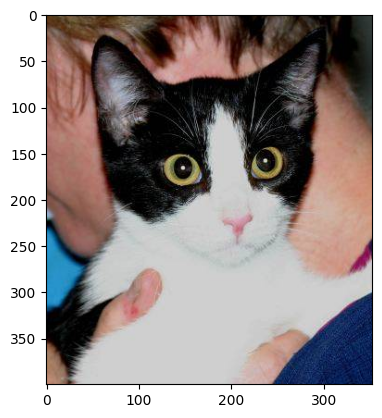

In [ ]:
# Show original image and the model's predicted classification
# 0 means cat, 1 means dog

catimage = Image.open('subset/validation/cats/cat.1009.jpg')
plt.imshow(catimage)
catimage = transform(catimage)
catimage = catimage.unsqueeze(0)

score = model(catimage)
print(score)

The below cell is creating an IntegratedGradients object from captum, and checking which input features are most important in determining the predicted outcome. The attributions_ig variable is a tensor that shows the relative importance of each feature from the given input, in this case the cat image from the above cell.

In [57]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig, apperror = integrated_gradients.attribute(
    catimage, target=0, return_convergence_delta=True
)
print(attributions_ig)
print(apperror)

tensor([[[[-1.8066e-05,  2.3181e-05,  3.7597e-05,  ..., -2.6187e-06,
           -1.3126e-06,  3.9470e-06],
          [-7.4142e-05,  8.2364e-05,  1.0707e-04,  ...,  3.6035e-06,
           -1.5270e-05,  5.9817e-06],
          [ 2.8857e-06,  6.3951e-05,  4.8456e-05,  ...,  4.8882e-06,
           -2.3103e-07,  6.4943e-06],
          ...,
          [-6.3614e-05, -9.0108e-04, -7.9854e-04,  ..., -2.4830e-06,
           -2.0958e-06, -1.6368e-06],
          [-4.7339e-04, -6.8968e-04, -6.3148e-04,  ..., -9.8519e-07,
            6.3129e-07, -3.0233e-06],
          [-6.2804e-05, -3.4029e-04, -3.9053e-04,  ...,  3.9817e-07,
            2.0397e-07, -1.3378e-07]],

         [[ 5.8875e-06, -2.7389e-05, -1.8107e-05,  ...,  9.8338e-06,
            5.4727e-06,  4.3127e-06],
          [-8.8038e-06, -4.7994e-05, -9.2456e-05,  ...,  1.6815e-05,
            2.5467e-05,  2.7371e-06],
          [-2.3430e-05,  1.6676e-05, -7.6259e-05,  ...,  7.4648e-06,
            1.6876e-05,  8.6458e-06],
          ...,
     

The below cells are taken from the tutorial video. They show the original image and a heatmap of important pixels used to classify the image side by side. This image I chose happens to have a pretty clear heatmap associated with it. In the heatmap, you can clearly see the outline of the cat's head and face, meaning the model used those pixels to determine that the image was in fact a cat.

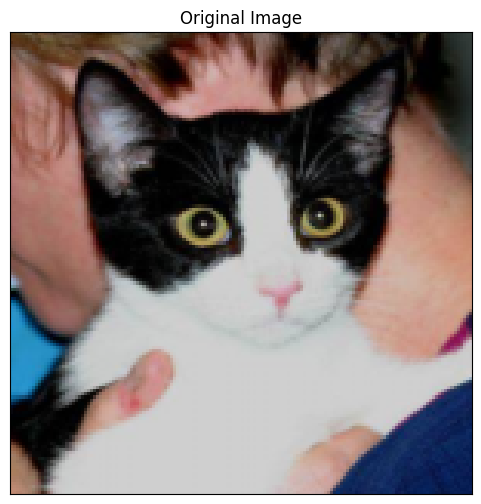

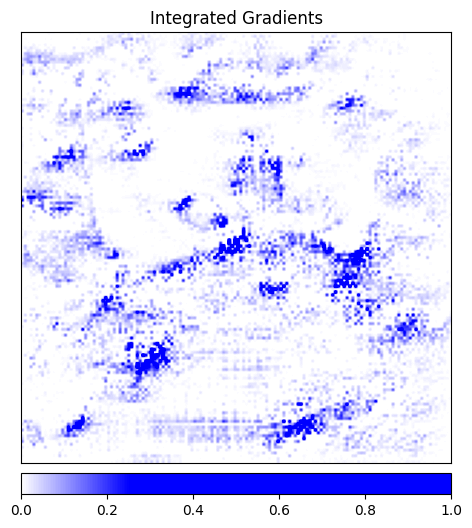

In [56]:
# Show the original image for comparison
_ = viz.visualize_image_attr(
    None,
    np.transpose(catimage.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method="original_image",
    title="Original Image",
)

default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#0000ff"), (1, "#0000ff")], N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(catimage.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method="heat_map",
    cmap=default_cmap,
    show_colorbar=True,
    sign="positive",
    title="Integrated Gradients",
)

